In [2]:
from gensim.models import Word2Vec

word2vec_model = Word2Vec.load("/kaggle/input/word2vec-large-2/word2vec_model_LARGE_2.bin")

In [3]:
def get_average_word2vec(sentence):
    word_vectors = []
    for word in sentence.split():
        if word in word2vec_model.wv:
            word_vectors.append(word2vec_model.wv[word])
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)


In [4]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

from datasets import load_dataset
dataset = load_dataset("yelp_review_full")

import pandas as pd
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])
x = train_df[:65000]['text']
y = train_df[:65000]['label']

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [5]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 5.6 MB/s eta 0:00:00


In [6]:
import json
import contractions
import re
slang_dict = json.load(open('/kaggle/input/english-slang/slang.json', 'r'))
def preprocess(text):
    # Convert text to UTF-8 encoding
    text = text.encode('utf-8').decode('utf-8')

    # Convert special characters
    text = text.lower().replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').replace('\\n', ' ').replace('\\r', ' ').replace('\\t', ' ')

    # Expand contractions
    text = contractions.fix(text)

    # Remove quotation marks around words
    text = re.sub(r'\"(\w+)\s*\"', r'\1', text)

    # Replace dots that are not between numbers with a space
    text = re.sub(r'(?<!\d)\.|\.(?!\d)', ' ', text)

    # Handle punctuation (excluding numbers)
    text = re.sub(r"[^\w\s\.]", r" ", text)

    # Handle dots at the end of sentences (excluding numbers)
    text = re.sub(r"\b\.(?!\d)", r" ", text)
    ## Replacing slangs
    words = text.split()
    corrected_slang_words = []
    for word in words:
        if word in slang_dict:
            word = slang_dict[word].lower()
        corrected_slang_words.append(word)

    return text

In [7]:
x_preprocessed = []
for text in x:
    x_preprocessed.append(preprocess(text))
x = x_preprocessed

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 2022)

In [9]:
# Assuming you have a list of sentences and their corresponding labels
sentences = x_train  # List of sentences
labels = y_train  # List of corresponding labels

# Convert labels to numeric values
label_to_numeric = {label: i for i, label in enumerate(set(labels))}
numeric_labels = np.array([label_to_numeric[label] for label in labels])

In [10]:
numeric_labels.shape

(52000,)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=10)
tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)

# Get the vocabulary and the tf-idf scores
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray()

In [13]:
len(tfidf_feature_names)

13261

In [14]:
tfidf_scores.shape

(52000, 13261)

In [15]:
feature_names_dict = {}
for i, name in enumerate(tfidf_feature_names.tolist()):
    feature_names_dict[name] = i
    

In [16]:
list(feature_names_dict.keys())[10000]

'roulette'

In [76]:
feature_names_dict['roulette']

10000

In [17]:
print(tfidf_scores[10000])

[0. 0. 0. ... 0. 0. 0.]


In [18]:
# Function to create TF-IDF weighted Word2Vec embedding for a document
def create_embedding(document, model, tfidf_vectorizer, tfidf_scores, feature_names_dict, i):
    words = document.split()
    doc_embedding = np.zeros(model.vector_size)
    weighted_sum = 0

    for word in words:
        if word in model.wv:
            tfidf_index = feature_names_dict[word] if word in feature_names_dict else -1
            if tfidf_index != -1:
                tfidf_score = tfidf_scores[tfidf_index]
                word_embedding = model.wv[word]
                doc_embedding += word_embedding * tfidf_score
                weighted_sum += tfidf_score

    if weighted_sum != 0:
        doc_embedding /= weighted_sum

    return doc_embedding


In [19]:
embeddings = np.array([create_embedding(doc, word2vec_model, tfidf_vectorizer, tfidf_scores[i], feature_names_dict, i) for i, doc in enumerate(sentences)])

In [20]:
embeddings.shape

(52000, 512)

In [21]:
labels.shape

(52000,)

In [ ]:
get_average_word2vec(sentences[0])

In [ ]:
embeddings[0]

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc


# Create a multinomial logistic regression classifier
classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=10000)

# Train the classifier
classifier.fit(embeddings, labels)


LogisticRegression(max_iter=10000, multi_class='multinomial')

In [23]:
classifier.n_iter_

array([429], dtype=int32)

In [24]:
tfidf_matrix_val = tfidf_vectorizer.transform(x_val)
tfidf_scores_val = tfidf_matrix_val.toarray()

In [25]:
tfidf_scores_val.shape

(13000, 13261)

In [26]:
embeddings_val = np.array([create_embedding(doc, word2vec_model, tfidf_vectorizer, tfidf_scores_val[i], feature_names_dict, i) for i, doc in enumerate(x_val)])

Accuracy: 0.5523076923076923
F1-Score: 0.5449360548158787
Confusion Matrix:
 [[2246  569  105   32   53]
 [ 690 1247  495  112   53]
 [ 186  557 1123  489  134]
 [  80  141  595 1134  567]
 [ 116   75  157  614 1430]]


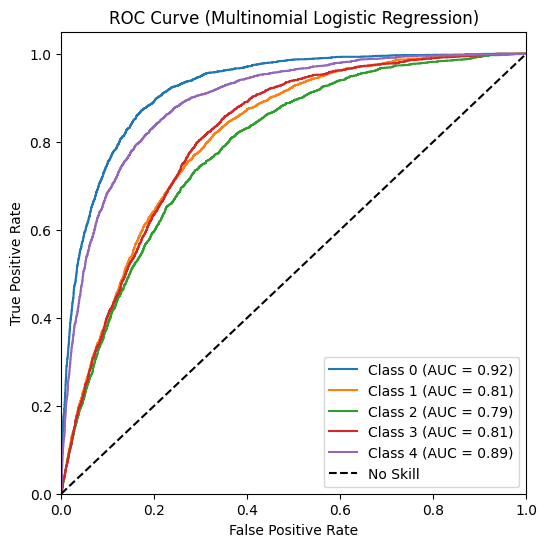

In [27]:
from sklearn.metrics import f1_score
# Predict class labels for test data
y_pred_val = classifier.predict(embeddings_val)

# Calculate Accuracy
accuracy = accuracy_score(y_val, y_pred_val)
print("Accuracy:", accuracy)
f1_score = f1_score(y_val, y_pred_val, average='macro')
print("F1-Score:", f1_score)

# Calculate Confusion Matrix
confusion_matrix_result = confusion_matrix(y_val, y_pred_val)
print("Confusion Matrix:\n", confusion_matrix_result)

# ROC Curve and AUC Score
# One-vs-Rest approach for ROC curve (as Multinomial Logistic Regression doesn't directly output probabilities)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(classifier.classes_)

for i in range(n_classes):
    y_test_binary = (y_val == i)  # Binarize for each class
    fpr[i], tpr[i], _ = roc_curve(y_test_binary, classifier.predict_proba(embeddings_val)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class %d (AUC = %0.2f)' % (i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multinomial Logistic Regression)')
plt.legend(loc="lower right")
plt.show()

In [87]:
classifier.n_features_in_

256

In [88]:
np.array(x_val).shape

(13000,)

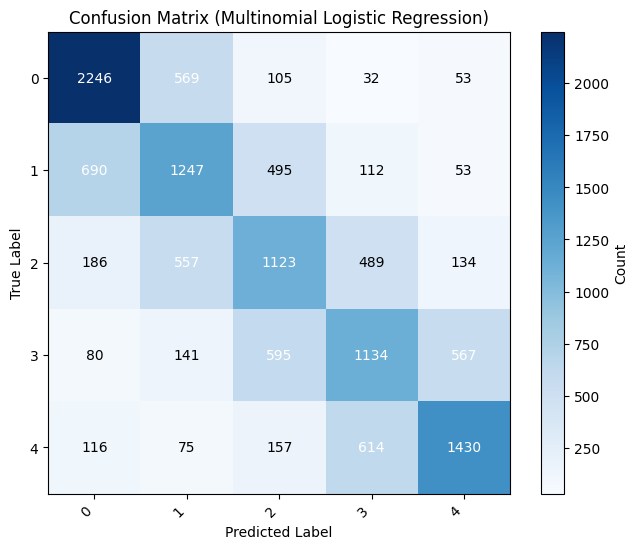

In [28]:
# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix_result, cmap='Blues')
plt.colorbar(label='Count')

# Set labels for axes
class_names = [str(x) for x in range(len(classifier.classes_))]  # Adapt based on your class names
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.yticks(range(len(class_names)), class_names)

# Add text for each cell (optional)
for i in range(len(confusion_matrix_result)):
    for j in range(len(confusion_matrix_result[0])):
        plt.text(j, i, confusion_matrix_result[i, j], ha='center', va='center', color='white' if confusion_matrix_result[i, j] > np.mean(confusion_matrix_result) else 'black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Multinomial Logistic Regression)')
plt.show()